#### In this code we have performed signal processing and anomaly detection, using clustering and statistical methods to identify unusual patterns in time-series seismic data that could be due to any subsurface geological features.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from obspy import read
from obspy.signal.filter import bandpass
from scipy.signal import hilbert, spectrogram, medfilt
import warnings
import pywt
from scipy.interpolate import interp1d
from scipy.fftpack import fft, fftfreq
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

- **Signal Processing Pipeline** : The code processes seismic data from .mseed files using a series of signal processing techniques. It applies a bandpass filter, removes spikes, and performs wavelet denoising to clean the data. The processed signals are then analyzed to extract features such as amplitude spectrum and instantaneous phase, which are visualized alongside the raw time-domain signals and spectrograms.
- **Visualization and Analysis** : For each seismic data file, the code generates a set of plots: the time-domain signal, amplitude spectrum, instantaneous phase, and spectrogram. These visualizations help in understanding the frequency content and phase information of the signals, providing insights into the underlying seismic activities.

Found 10 mseed files in module_8_data/data


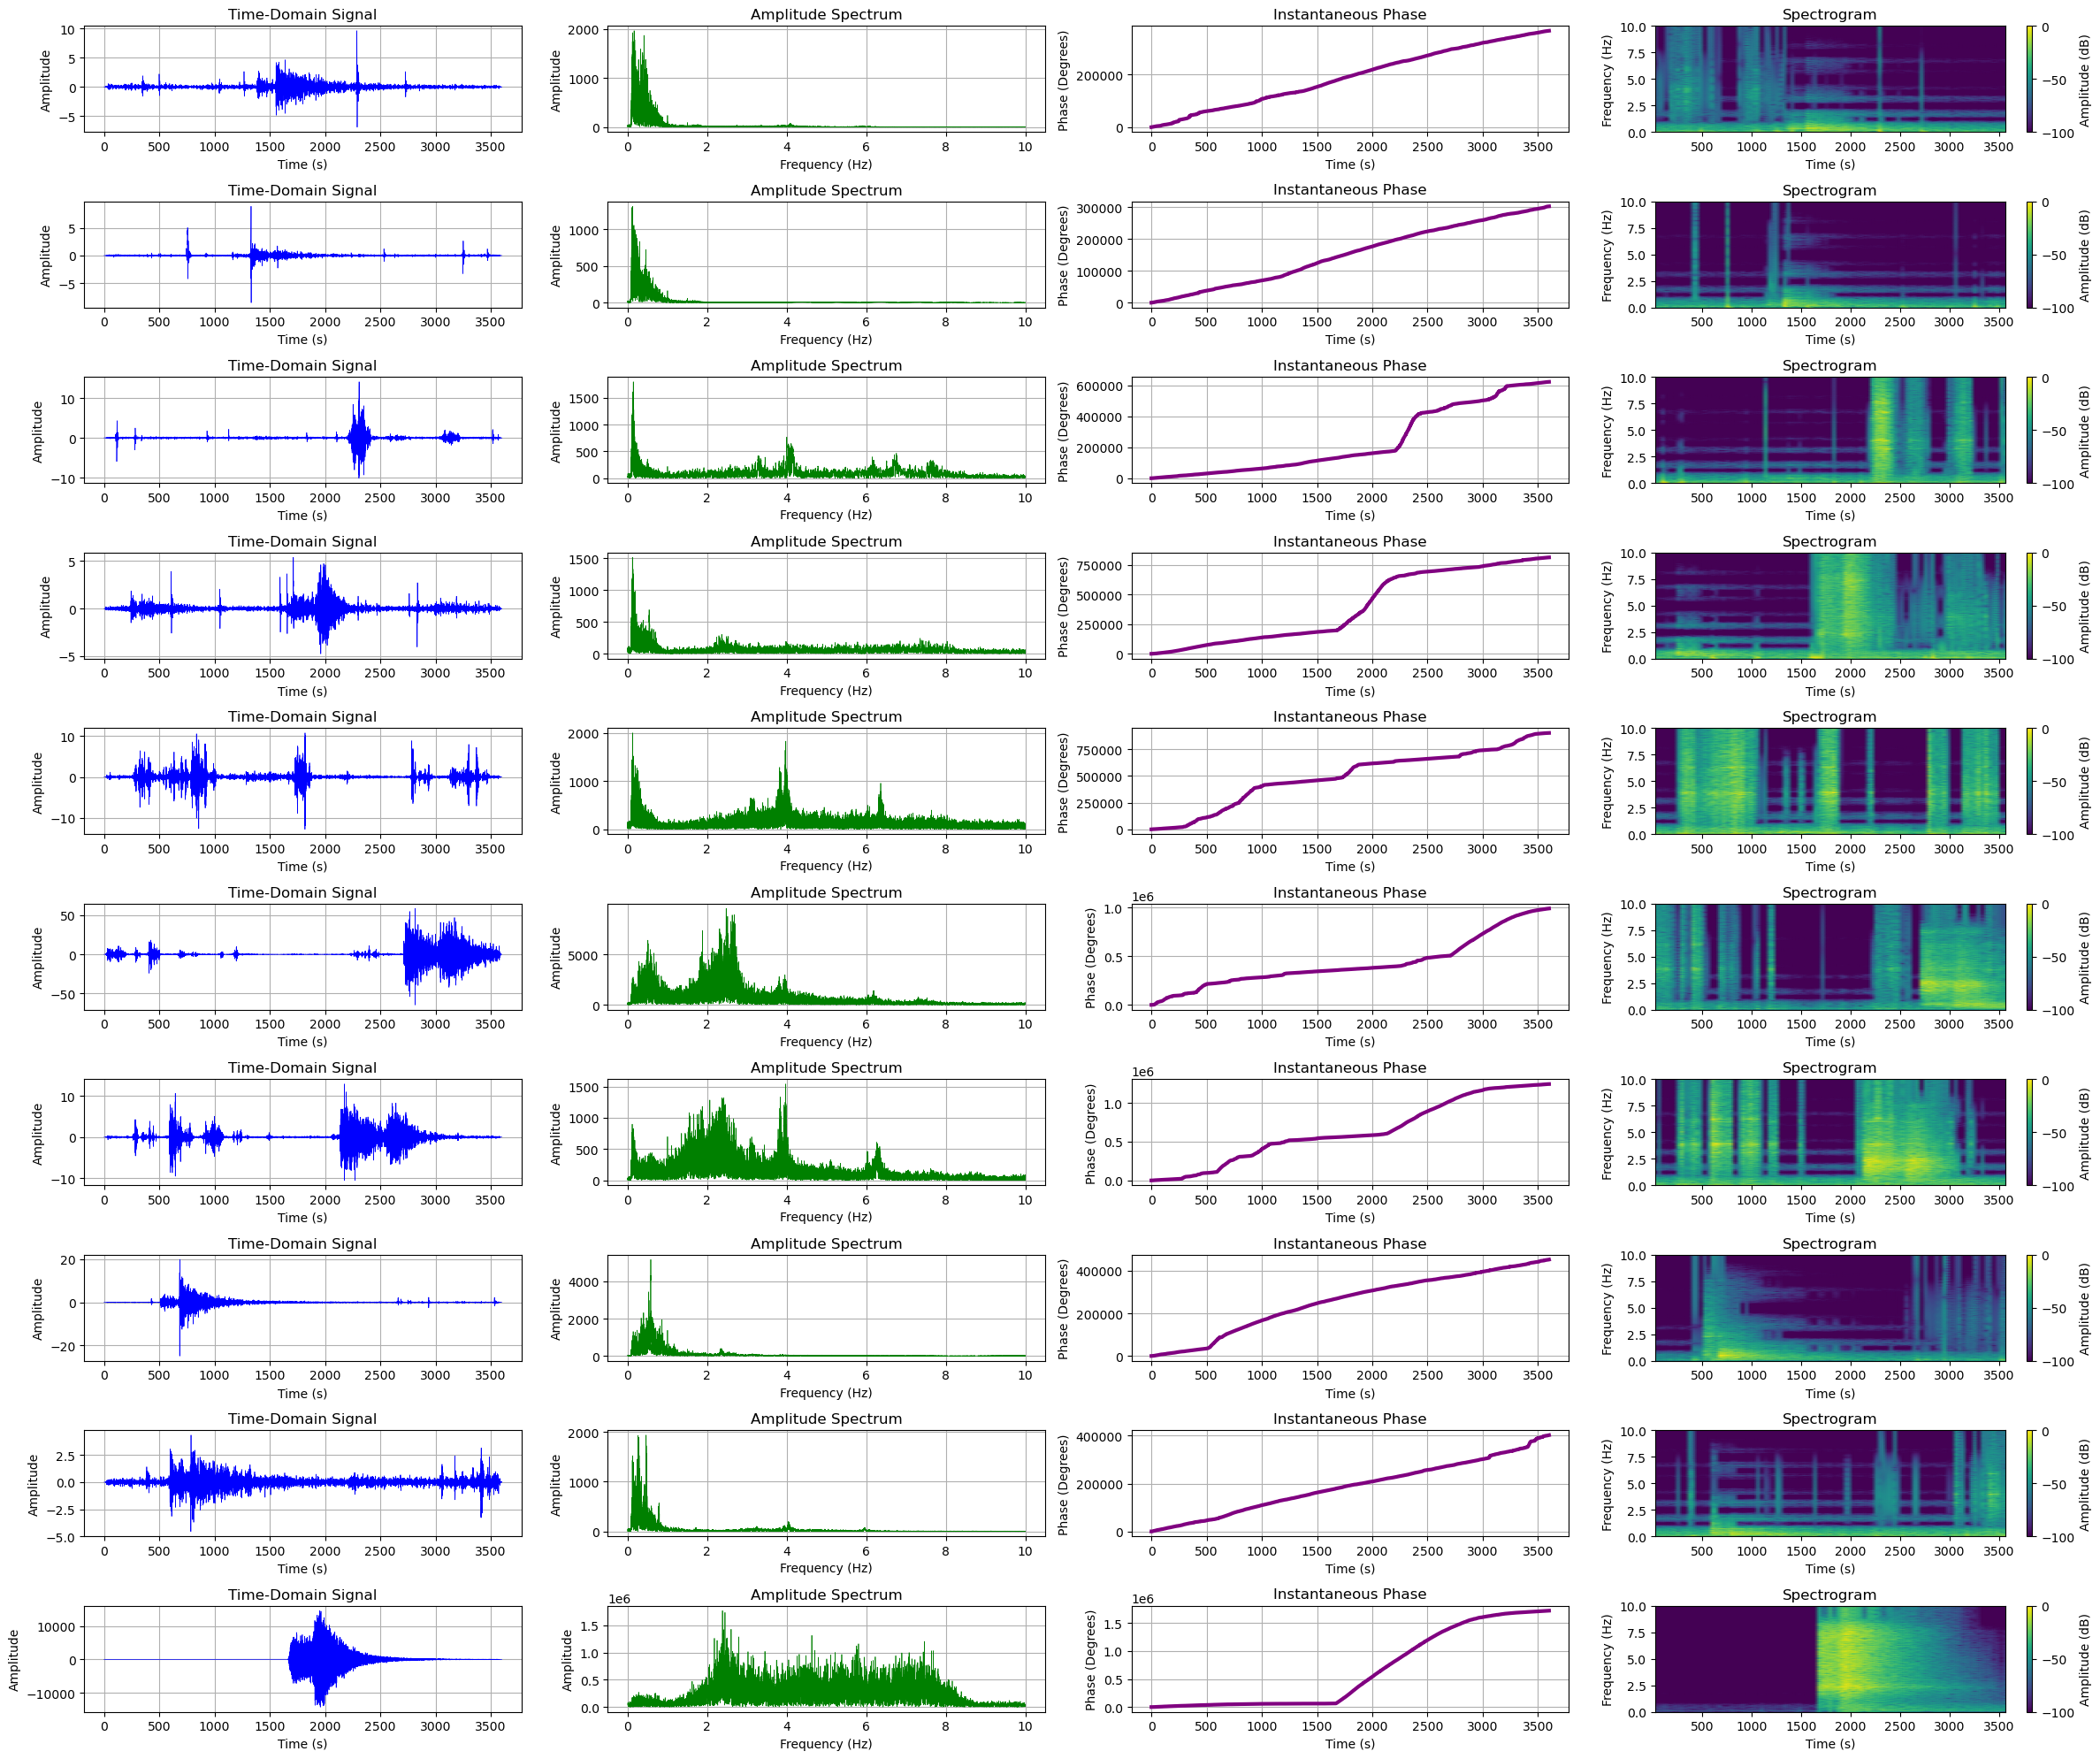

In [5]:
def bandpass_filter(data, sampling_rate, freqmin, freqmax):
    return bandpass(data, freqmin=freqmin, freqmax=freqmax, df=sampling_rate, corners=4, zerophase=True)

def wavelet_denoise(data, wavelet="db6", max_level=4):
    coeffs = pywt.wavedec(data, wavelet, level=max_level)
    threshold = np.sqrt(2 * np.log(len(data))) * np.median(np.abs(coeffs[-1])) / 0.6745
    denoised_coeffs = [coeffs[0]]
    for i in range(1, len(coeffs)):
        denoised_coeffs.append(pywt.threshold(coeffs[i], threshold, mode="soft"))
    return pywt.waverec(denoised_coeffs, wavelet)

def remove_spikes(data, z_threshold=3, window_size=60):
    data = np.asarray(data)
    cleaned_data = data.copy()

    half_window = window_size // 2
    local_mean = np.convolve(data, np.ones(window_size) / window_size, mode='same')
    local_std = np.sqrt(np.convolve((data - local_mean)**2, np.ones(window_size) / window_size, mode='same'))
    
    z_scores = np.abs(data - local_mean) / (local_std + 1e-8) 
    spikes = z_scores > z_threshold
    
    spike_indices = np.where(spikes)[0]
    valid_indices = np.where(~spikes)[0]
    interpolator = interp1d(valid_indices, data[valid_indices], kind="linear", fill_value="extrapolate")
    cleaned_data[spike_indices] = interpolator(spike_indices)
    
    return cleaned_data

warnings.filterwarnings("ignore", category=UserWarning)
directory_path = r"module_8_data/data" 
mseed_files = glob.glob(os.path.join(directory_path, "*.mseed"))
mseed_files.sort() 

print(f"Found {len(mseed_files)} mseed files in {directory_path}")
fig, axes = plt.subplots(nrows=len(mseed_files), ncols=4, figsize=(24, 2 * len(mseed_files)))

signals = []
times = []
fs = []
p_freq = []
p_amp = []
phase = []

for i, mseed_file in enumerate(mseed_files):
    st = read(mseed_file)
    st.filter('bandpass', freqmin=0.1, freqmax=50.0)
    tr = st[0] 
    sampling_rate = tr.stats.sampling_rate
    
    data = tr.data.astype(np.float32) / (100)
    filtered_data = bandpass_filter(data, sampling_rate, freqmin=0.1, freqmax=25.0)
    spike_removed_data = remove_spikes(filtered_data)
    wavelet_denoised_data = wavelet_denoise(spike_removed_data)
    data = remove_spikes(wavelet_denoised_data)
    
    time = tr.times()
    ax_raw = axes[i, 0]
    ax_denoised = axes[i, 1]
    
    n = len(data)
    frequencies = fftfreq(n, d=1 / sampling_rate)
    fft_values = fft(data)
    amplitude_spectrum = np.abs(fft_values)

    positive_frequencies = frequencies[:n // 2]
    positive_amplitudes = amplitude_spectrum[:n // 2]

    analytic_signal = hilbert(data)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))

    # (a) Time-Domain Signal
    axes[i, 0].plot(time, data[:len(time)], color='blue', linewidth=0.5)
    axes[i, 0].set_title("Time-Domain Signal")
    axes[i, 0].set_xlabel("Time (s)")
    axes[i, 0].set_ylabel("Amplitude")
    axes[i, 0].grid()

    # (b) Amplitude Spectrum
    axes[i, 1].plot(positive_frequencies, positive_amplitudes, color='green', linewidth=0.5)
    axes[i, 1].set_title("Amplitude Spectrum")
    axes[i, 1].set_xlabel("Frequency (Hz)")
    axes[i, 1].set_ylabel("Amplitude")
    axes[i, 1].grid()

    # (c) Instantaneous Phase
    axes[i, 2].plot(time, np.degrees(instantaneous_phase[:len(time)]), color='purple', linewidth=3)
    axes[i, 2].set_title("Instantaneous Phase")
    axes[i, 2].set_xlabel("Time (s)")
    axes[i, 2].set_ylabel("Phase (Degrees)")
    axes[i, 2].grid()

    # (d) Spectrogram
    f, t_spec, Sxx = spectrogram(data, fs=sampling_rate, nperseg=1024, noverlap=256)
    Sxx_dB = 10 * np.log10(Sxx / np.max(Sxx) + 1e-10)
    im = axes[i, 3].pcolormesh(t_spec, f, Sxx_dB, shading='gouraud', cmap='viridis')
    fig.colorbar(im, ax=axes[i, 3], label="Amplitude (dB)")
    axes[i, 3].set_title("Spectrogram")
    axes[i, 3].set_xlabel("Time (s)")
    axes[i, 3].set_ylabel("Frequency (Hz)")
    
    signals.append(data)
    times.append(time)
    fs.append(int(sampling_rate))
    p_amp.append(positive_amplitudes)
    p_freq.append(positive_frequencies)
    phase.append(instantaneous_phase)

plt.tight_layout()
plt.show()

- **Anomaly Detection in Signal Data** : The code implements anomaly detection on signal data using the DBSCAN clustering algorithm and statistical methods. It processes chunks of data to identify anomalies based on clustering results and deviations from the mean, marking these anomalies in time-domain signals, amplitude spectra, and phase data.
- **Visualization of Signal Analysis** : The plot_signals_analysis function visualizes the processed signals, displaying time-domain plots, amplitude spectra, and instantaneous phase plots. It highlights detected anomalies in each plot, providing a comprehensive view of the signal characteristics and potential irregularities.

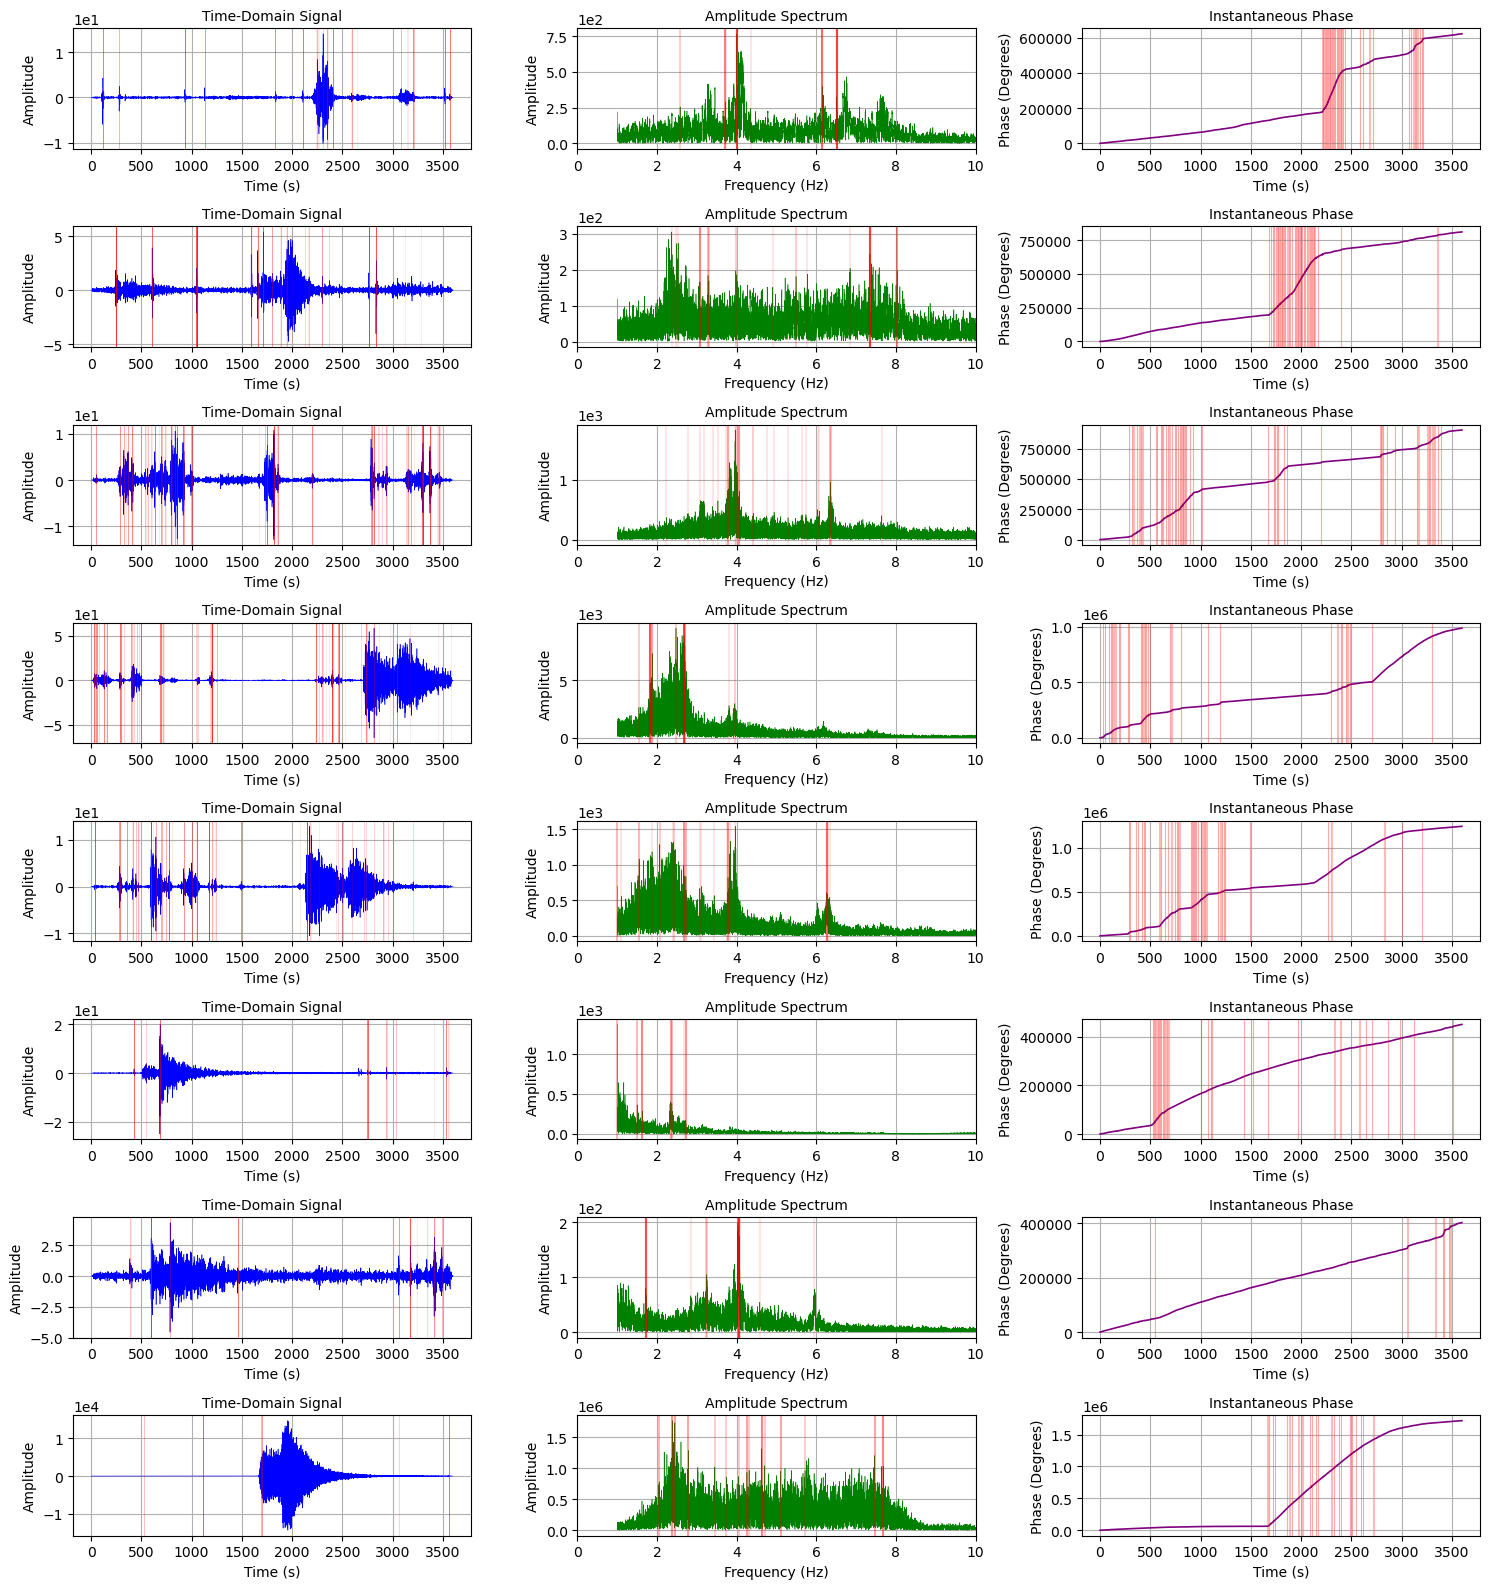

In [6]:
def dbscan(data, eps=0.8, min_samples=50, chunk_size=1000, threshold_factor=3.0):
    data = np.asarray(data).ravel()
    anomalies = np.zeros(len(data), dtype=bool)
    
    for i in range(0, len(data), chunk_size):
        chunk = data[i:i + chunk_size]
        chunk_reshaped = chunk.reshape(-1, 1)
        
        scaler = StandardScaler()
        chunk_scaled = scaler.fit_transform(chunk_reshaped)
        clusters = DBSCAN(
                eps=eps,
                min_samples=min(min_samples, len(chunk) // 5),
                metric='euclidean'
            ).fit_predict(chunk_scaled)
            
        statistical_anomalies = np.abs(chunk - np.mean(chunk)) > threshold_factor * np.std(chunk)
        chunk_anomalies = (clusters == -1) & statistical_anomalies
        anomalies[i:i + len(chunk)] = chunk_anomalies
    
    return anomalies

def phase_changes(phase_data, window=101, threshold=5.0):
    gradient = np.gradient(phase_data)
    smoothed_gradient = medfilt(gradient, window)
    slope_changes = np.gradient(smoothed_gradient)
    
    normalized_changes = np.abs(slope_changes) / np.std(slope_changes)
    anomalies = normalized_changes > threshold
    
    min_distance = window * 2 
    clustered_anomalies = np.zeros_like(anomalies)
    last_anomaly = -min_distance
    
    for i in np.where(anomalies)[0]:
        if i - last_anomaly > min_distance:
            region_start = max(0, i - window//4)
            region_end = min(len(anomalies), i + window//4)
            clustered_anomalies[region_start:region_end] = True
            last_anomaly = i
    
    return clustered_anomalies

def plot_signals_analysis(signals, fs, p_freq, p_amp, phase):
    n_signals = len(signals)
    fig, axs = plt.subplots(n_signals, 3, figsize=(15, 2*n_signals))
    
    for i in range(n_signals):
        time_points = np.arange(len(signals[i])) / fs[i]
        
        axs[i,0].plot(time_points, signals[i], 'b-', linewidth=0.4)
        amp_anomalies = dbscan(
            signals[i], 
            eps= 0.5, 
            min_samples=100,
            chunk_size=min(1000, len(signals[i])),
            threshold_factor=4.0
        )
        for idx in np.where(amp_anomalies)[0]:
            axs[i,0].axvline(x=time_points[idx], color='r', alpha=0.1, linewidth=0.6)
        
        axs[i,0].set_title('Time-Domain Signal', fontsize=10)
        axs[i,0].set_xlabel('Time (s)')
        axs[i,0].set_ylabel('Amplitude')
        axs[i,0].grid(True)
        axs[i,0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        
        freq_mask = (p_freq[i] <= 10) & (p_freq[i] >= 1)
        amp_data = p_amp[i][freq_mask]
        freq_data = p_freq[i][freq_mask]
        
        freq_anomalies = dbscan(
            amp_data, 
            eps=0.8, 
            min_samples=200,
            chunk_size=min(1000, len(amp_data)),
            threshold_factor=3.5
        )
        
        axs[i,1].plot(freq_data, amp_data, 'g-', linewidth=0.4)
        anomaly_indices = np.where(freq_anomalies)[0]
        for idx in anomaly_indices:
            if amp_data[idx] > np.mean(amp_data) + 2 * np.std(amp_data):
                axs[i,1].axvline(x=freq_data[idx], color='r', alpha=0.1, linewidth=1.5)
        
        axs[i,1].set_title('Amplitude Spectrum', fontsize=10)
        axs[i,1].set_xlabel('Frequency (Hz)')
        axs[i,1].set_ylabel('Amplitude')
        axs[i,1].grid(True)
        axs[i,1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        axs[i,1].set_xlim(0, 10)
        
        phase_data = np.degrees(phase[i])
        phase_anomalies = phase_changes(phase_data, threshold=7.0)
        
        axs[i,2].plot(time_points, phase_data, 'purple', linewidth=1.2)
        prev_anomaly = False
        region_start = None
        
        for j in range(len(phase_anomalies)):
            if phase_anomalies[j] and not prev_anomaly:
                region_start = time_points[j]
            elif not phase_anomalies[j] and prev_anomaly:
                if region_start is not None:
                    axs[i,2].axvspan(region_start, time_points[j], 
                                   color='red', alpha=0.1)
                    axs[i,2].axvline(x=region_start, color='r', 
                                   alpha=0.2, linewidth=0.5)
                    axs[i,2].axvline(x=time_points[j], color='r', 
                                   alpha=0.2, linewidth=0.5)
            prev_anomaly = phase_anomalies[j]
        
        axs[i,2].set_title('Instantaneous Phase', fontsize=10)
        axs[i,2].set_xlabel('Time (s)')
        axs[i,2].set_ylabel('Phase (Degrees)')
        axs[i,2].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_signals_analysis(signals[-8:], fs[-8:], p_freq[-8:], p_amp[-8:], phase[-8:])